# Quarter 2: Project

The main deliverable for the second quarter of the computational economics and finance class is a project to showcase what you have learned. The goal of this project is for you (potentially in a small group) to produce a piece of work (in the form of a Jupyter notebook) that you would be able to use to showcase the skills that you have learned in this class to potential employers or academic advisors.

The relatively loose structure in self-directed projects like this makes them a bit more challenging than other things that you will do in school, but we think it also makes them more interesting. They give you a chance to indulge your curiosity and show off your creativity.

We have broken the project into three components to keep you on track. Each of these components should be turned in as its own Jupyter notebook. The first two steps are graded almost entirely on whether you do them or not. You must complete the first two steps on your own. When you actually begin working on the final project, you may work in groups of two to four, but you may also work alone if you’d  prefer.

# Outline

- [Project Ideas](#Project-Ideas)
- [Proposal](#Proposal)
  - [Project Proposals](#Project-Proposals)
  - [Prior](#Prior)
- [Introduction](#Introduction)
  - [Data of VIX Index](#Data-of-VIX-Index)
  - [Data with covid-19](#Data-with-covid-19)
- [Frequentist Model](#Frequentis-Model)
  - [Fitting SP500 returns by ARCH model](#1)
  - [Fitting US VIX by ARX model](#2)
- [Topic 3](#Topic-3)
  -
  -
  -

# Project Ideas

**(15% of project grade)**

Form a team of between one and four students (no more) and choose a project. This project could come from the ideas that you submitted or some other idea if you get a sudden flash of inspiration. Flesh out the project in detail -- When we say “flesh it out in detail”, we mean properly load the data into the notebook, describe in words what you want to explore, and create a couple draft quality visualizations (don’t worry about making them pretty) that whets a reader’s appetite.

Please include the names of all group members in the below:

* Jian Zhou
* Bo Sun
* Man Chen


**Please note that each person should make a copy of the notebook and turn it in!**


# Proposal
Include your project proposal, data, and graphs in the cells below

## Project Proposals

The stochastic volatility model is the canonical method to model asset return volatility. Nonetheless, the stochastic models usually don’t have closed-form analytic solution and computational-heavy to calibrate due to model complexity. Monte Carlo Markov Chain has grown to be one of the most effective and popular tools in analyzing the stochastic volatility model. Priors and data are fed into the model, and posteriors are the calibrated model parameters of interest. 

We have noticed that the VIX index has been rather volatile since the outbreak of COVID-19 and peaked in March 2019. The traditional stochastic volatility fails to capture the spike due to the inactivity to internalize exogenous shock.  

We proposed to extend the canonical stochastic volatility to incorporate covid-19 data under a Monte Carlo Markov Chain framework. The following formulas set the extended stochastic volatility model.

Mathematically speaking, the cannonical stochastic volatility model follows the below setting, where $\sigma_\eta$ is the scale parameter.

\begin{align*}
\qquad & y_t = \beta e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta} \eta_{t-1}  \qquad \qquad &\eta_{t-1} \sim N(0,1) \quad \beta \sim N(1,10) \\
\qquad &  h_1 \sim N(\mu, \sigma_\eta^2/(1-\phi^2)) \\
\end{align*}

The extended stochastic volatility model follows the below setting. The key difference is that $\sigma_\eta$ is no more time-invariant, instead, is a random walk with drift decided by covid-19 data.

\begin{align*}
\qquad & y_t = \beta e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta,t-1} \eta_{t-1}  \qquad \qquad &\eta_{t-1} \sim N(0,1) \quad \beta \sim N(1,10) \\
\qquad &  h_1 \sim N(\mu, \sigma_\eta^2/(1-\phi^2)) \\
\qquad & \color{red}{ \sigma_{\eta,t} =  \sigma_{\eta,t-1} + \alpha(lnC_t - lnC_{t-1}) + u_t} \qquad \qquad &u_t \sim N(0,1) \\
\qquad &  \color{red} {\sigma_{\eta,1} \sim N(1, 10)}
\end{align*}

We plan to sample and calibrate the extended stochastic volatility model. Furthermore, we will conduct a model comparison to check whether the comprehensive model supersedes the canonical model. 


In [43]:
import arviz as az
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import yfinance as yf
import os

%matplotlib inline
%config Completer.use_jedi = False

# Introduction

## Data of VIX Index

As we have mentioned before in our project proposal, according to the assumption of the cannonical stochastic volatility model, the distribution of the volatility parameter $\sigma_\eta$ does not change with time. We will see that whether the volitility of financial market is time-invariant during covid-19.

First we will show the data of CBOE Volatility Index(VIX) during covid-19.The data was downloaded from Yahoo Finance:

In [44]:
# load sp500 and vix data use yfinance
_finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
_finance_data = _finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX', '^INDIAVIX':'India_VIX'}, axis=1)
_finance_data.head(2)

[*********************100%***********************]  2 of 2 completed


,SP500,VIX
Date,,
2017-01-03,2257.830078,12.85
2017-01-04,2270.750000,11.85


We plot the graph of VIX index:

<AxesSubplot:title={'center':'VIX Index'}, xlabel='Date'>

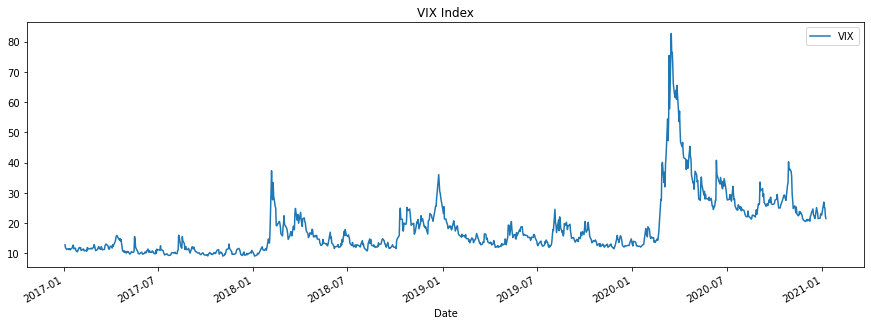

In [45]:
_finance_data.plot(y=['VIX'],use_index=True, figsize=(15,5),title="VIX Index")

In our project, we will set 2020-01-22 as the beginning of covid-19.The graph shows that:
* Before covid-19,, VIX did not fluctuate greatly.
* After covid-19 broke out, espically in the fisrt several months, VIX raised rapidly and reached a peak, which may not be consistent with the assumption that the volatility is time-invariant.

Then, our group researched on the volatility index of India, Hong Kong,Japan and Eurozone(Actually, it may be a great pity that there is no VIX index in the mainland of China, so we replace it with Hong Kong as it is one of the most important financial centers in the world and its market is closedly related to the mainland's).We downloaded those datas from Google and here are the datas:

In [46]:
IDVIX = pd.read_csv(os.path.join(os.curdir,"Data/IDIndex.csv")).pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'IDVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

IDVIX.index = IDVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
finance_data = _finance_data.merge(IDVIX, left_index=True, right_index=True)
finance_data.head(2)

,SP500,VIX,IDVIX
Date,,,
2019-02-28,2784.489990,14.78,18.2775
2019-03-01,2803.689941,13.57,16.2750


In [47]:
VHSI = pd.read_csv(os.path.join(os.curdir,"Data/VHSI.csv")).pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'VHSI'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

VHSI.index = VHSI.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
finance_data = finance_data.merge(VHSI, left_index=True, right_index=True)
finance_data.head(2)

,SP500,VIX,IDVIX,VHSI
Date,,,,
2019-02-28,2784.489990,14.78,18.2775,18.93
2019-03-01,2803.689941,13.57,16.2750,17.10


In [48]:
JPVIX = pd.read_csv(os.path.join(os.curdir,"Data/JPIndex.csv")).pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'JPVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

JPVIX.index = JPVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%Y.%m.%d'))
finance_data = finance_data.merge(JPVIX, left_index=True, right_index=True)
finance_data.head(2) 

,SP500,VIX,IDVIX,VHSI,JPVIX
Date,,,,,
2019-02-28,2784.489990,14.78,18.2775,18.93,1.52
2019-03-01,2803.689941,13.57,16.2750,17.10,1.43


In [49]:
EUVIX = pd.read_csv(os.path.join(os.curdir,"Data/EUIndex.csv")).pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) \
.pipe(pd.DataFrame.rename, {'Close':'EUVIX'}, axis=1) \
.pipe(pd.DataFrame.set_index, ['Date']) \

EUVIX.index = EUVIX.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%Y'))
finance_data = finance_data.merge(EUVIX, left_index=True, right_index=True)
finance_data.head(2) 

,SP500,VIX,IDVIX,VHSI,JPVIX,EUVIX
Date,,,,,,
2019-02-28,2784.489990,14.78,18.2775,18.93,1.52,14.78
2019-03-01,2803.689941,13.57,16.2750,17.10,1.43,13.57


After collecting the datas, we plot them on the graph:

In [50]:
Finance2=finance_data.drop(columns=['SP500'])

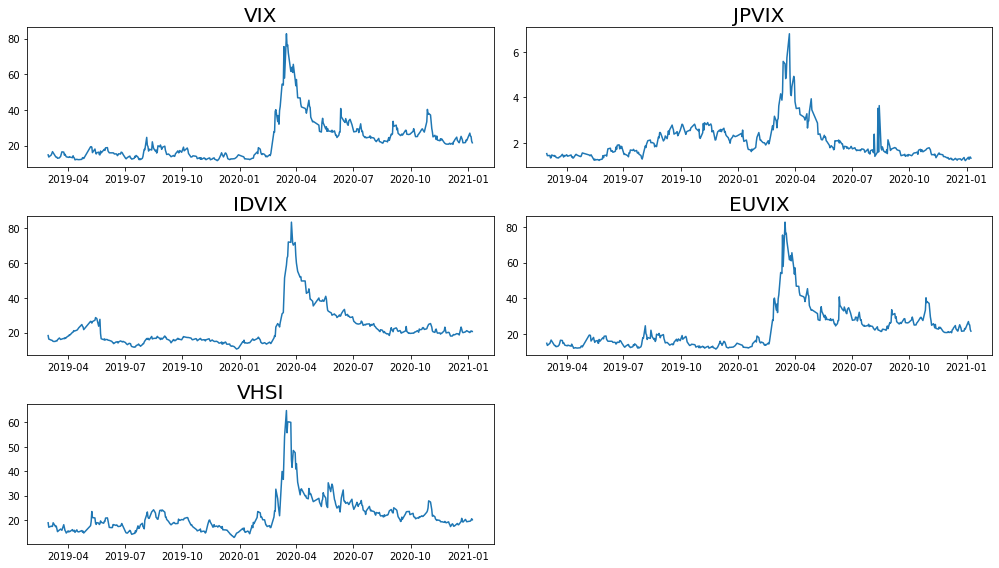

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(14, 8))
fig.delaxes(ax[2,1])
ax[0, 0].set_title('VIX',fontsize=20)
ax[0, 0].plot(Finance2.index, Finance2.VIX)
ax[1, 0].set_title('IDVIX',fontsize=20)
ax[1, 0].plot(Finance2.index, Finance2.IDVIX)
ax[2, 0].set_title('VHSI',fontsize=20)
ax[2, 0].plot(Finance2.index, Finance2.VHSI)
ax[0, 1].set_title('JPVIX',fontsize=20,)
ax[0, 1].plot(Finance2.index, Finance2.JPVIX)
ax[1, 1].set_title('EUVIX',fontsize=20)
ax[1, 1].plot(Finance2.index, Finance2.EUVIX)
plt.tight_layout()

According the the graph, all indices have a great peak after covid-19.(And maybe we can notice that the financial market of Japan is much more stable than that of other financial market).

In conclusion, obviously, the vix indices of these financial market reached a great peak after the broke up of covid-19, which may be a great challenge of "time-invariant volatility" consumption. To get more details of it, we will add the data of covid-19 into our research:

## Data with covid-19

We download the data of covid-19 from Johns Hopkins Coronavirus Resource Center.By using the methods learned from our classes, we merged these data to a total dataset of all countries and regions we researched on:

In [52]:
_covid_19 =pd.read_csv(os.path.join(os.curdir, "Data/covid.csv"))


covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19['global'] = covid_19.apply('sum', axis=1)

# calculate the cases growth in each country
covid_19_country = pd.DataFrame(index=covid_19.index)
for country in covid_19.columns.unique():
        covid_19_country['cases_growth_' + country] = np.log(covid_19[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)                                  


# # calculate the cases growth in US
# covid_19['cases_growth_US'] = np.log(covid_19['US']).diff().rolling(14, win_type='gaussian').mean(std=3)


# calculate the cases growth globally
covid_19_country['cases_growth_global'] = covid_19_country.mean(axis=1)

covid_19_data = covid_19[['US', 'global']].merge(covid_19_country[['cases_growth_US', 
                                                                   'cases_growth_global', 
                                                                   'cases_growth_India',
                                                                   'cases_growth_Japan']], 
                                                 left_index=True, right_index=True)
covid_19_data=covid_19_data.drop(columns=['US','global'])

In [53]:
_covid_19HK =pd.read_csv(os.path.join(os.curdir, "Data/HKcovid.csv"))
covid_19HK = _covid_19HK.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
covid_19_HK= np.array(np.log(covid_19HK[['Hong Kong']].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3))       
covid_19HK['cases_growth_HK']=covid_19_HK

In [54]:
covid_19_data=covid_19_data.merge(covid_19HK,left_index=True, right_index=True)
covid_19_data=covid_19_data.drop(columns=['Hong Kong'])

In [55]:
_covid_19EU =pd.read_csv(os.path.join(os.curdir, "Data/EUcovid.csv"))


covid_19EU = _covid_19EU.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1) \
        .pipe(pd.DataFrame.set_index, 'Country/Region').T
        
covid_19EU['EU'] = covid_19EU.apply('sum', axis=1)

# calculate the cases growth in each country in Eurozone
covid_19_EUcountry = pd.DataFrame(index=covid_19EU.index)
for country in covid_19EU.columns.unique():
        covid_19_EUcountry['cases_growth_' + country] = np.log(covid_19EU[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)                                  


covid_19_EUcountry['cases_growth_EU'] = covid_19_EUcountry.mean(axis=1)

In [56]:
covid_19_data=covid_19_data.merge(covid_19_EUcountry['cases_growth_EU'],left_index=True, right_index=True)

In [57]:
covid_19_data=covid_19_data.drop(index=['Unnamed: 0'])
covid_19_data=covid_19_data.fillna(0)

In [58]:
covid_19_data.index = [datetime.datetime.strptime(i, '%m/%d/%y') for i in covid_19_data.index]

After doing these, we start to combine them with the VIX data:

In [59]:
Finance_data=finance_data

In [60]:
Covid_19_data=covid_19_data

In [61]:
Finance_data

,SP500,VIX,IDVIX,VHSI,JPVIX,EUVIX
Date,,,,,,
2019-02-28,2784.489990,14.780000,18.2775,18.93,1.52,14.78
2019-03-01,2803.689941,13.570000,16.2750,17.10,1.43,13.57
2019-03-05,2789.649902,14.740000,15.6575,17.55,1.44,14.74
2019-03-06,2771.449951,15.740000,15.6100,17.41,1.33,15.74
2019-03-07,2748.929932,16.590000,15.2925,17.51,1.34,16.59
...,...,...,...,...,...,...
2021-01-04,3700.649902,26.969999,20.0300,19.55,1.36,26.97
2021-01-05,3726.860107,25.340000,20.4600,19.63,1.27,25.34
2021-01-06,3748.139893,25.070000,20.9950,20.02,1.36,25.07


In [62]:
Covid_19_data

,cases_growth_US,cases_growth_global,cases_growth_India,cases_growth_Japan,cases_growth_HK,cases_growth_EU
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2021-01-27,0.007188,0.007723,0.001291,0.015087,0.007208,0.008253
2021-01-28,0.006974,0.007616,0.001284,0.014146,0.007142,0.008111
2021-01-29,0.006765,0.007519,0.001270,0.013208,0.006975,0.007948
2021-01-30,0.006567,0.007417,0.001255,0.012327,0.006712,0.007797


In [63]:
data = Finance_data.merge(Covid_19_data, left_index=True, right_index=True)
data.tail(3)

,SP500,VIX,IDVIX,VHSI,JPVIX,EUVIX,cases_growth_US,cases_growth_global,cases_growth_India,cases_growth_Japan,cases_growth_HK,cases_growth_EU
2020-12-28,3735.360107,21.700001,20.4275,20.31,1.35,21.70,0.011029,0.008052,0.002303,0.014398,0.009012,0.012027
2020-12-29,3727.040039,23.080000,20.7900,19.85,1.26,23.08,0.010624,0.007970,0.002253,0.014677,0.008502,0.011666
2020-12-30,3732.040039,22.770000,21.1100,19.36,1.21,22.77,0.010267,0.007858,0.002200,0.014978,0.008069,0.011299


Firsrly, we show the covid datas of all countries and regions we researched on:

In [64]:
data2=data[['cases_growth_global','cases_growth_US','cases_growth_India','cases_growth_Japan','cases_growth_HK','cases_growth_EU']]
data2.index.name='Date'
data2.columns.name='Cases_growth'

Text(0.5, 1.0, 'Cases_growth_EU')

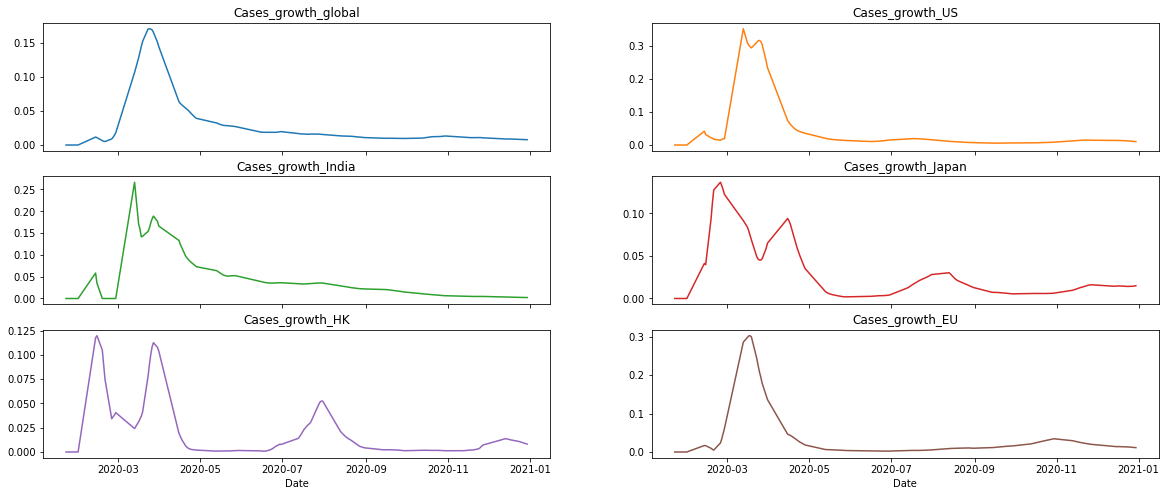

In [65]:
fig,axs=plt.subplots(3,2,figsize=(20,8))

data2.plot(ax=axs,subplots=True,legend=False)
axs[0][0].set_title('Cases_growth_global')
axs[0][0].set_xlabel('')
axs[0][0].tick_params(labelbottom=False)
axs[0][1].set_title('Cases_growth_US')
axs[0][1].set_xlabel('')
axs[0][1].tick_params(labelbottom=False)
axs[1][0].set_title('Cases_growth_India')
axs[1][0].set_xlabel('')
axs[1][0].tick_params(labelbottom=False)
axs[1][1].set_title('Cases_growth_Japan')
axs[1][1].set_xlabel('')
axs[1][1].tick_params(labelbottom=False)
axs[2][0].set_title('Cases_growth_HK')
axs[2][1].set_title('Cases_growth_EU')


Then, we will draw the covid data and the volatility data of each country or region(the later one will be drawn **with black dotted line** separately. And in each graph we will also draw the graph of the global covid data.

Here is the situation of VIX in the United States:

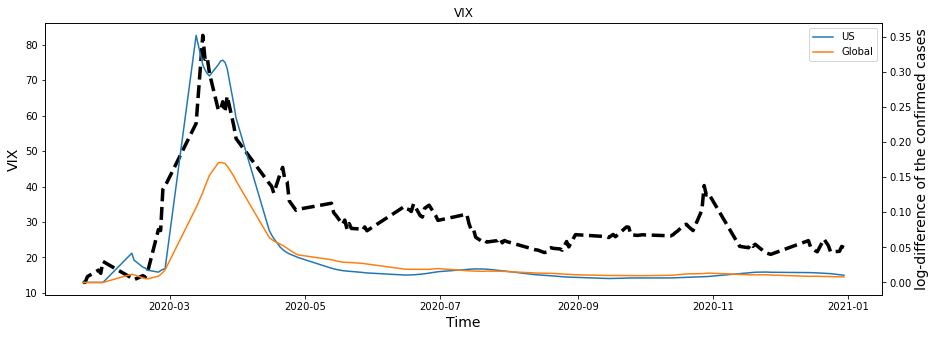

In [66]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.VIX, 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_US'], label="US")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("VIX")
plt.legend()
plt.show()

Here is the situation of IDVIX in India:

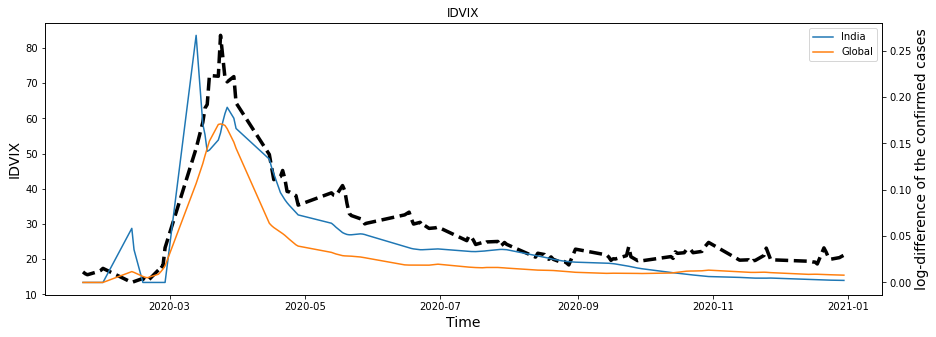

In [67]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.IDVIX, 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("IDVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_India'], label="India")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_India'], label='India')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("IDVIX")
plt.legend()
plt.show()

Here is the situation of JPVIX in Japan:

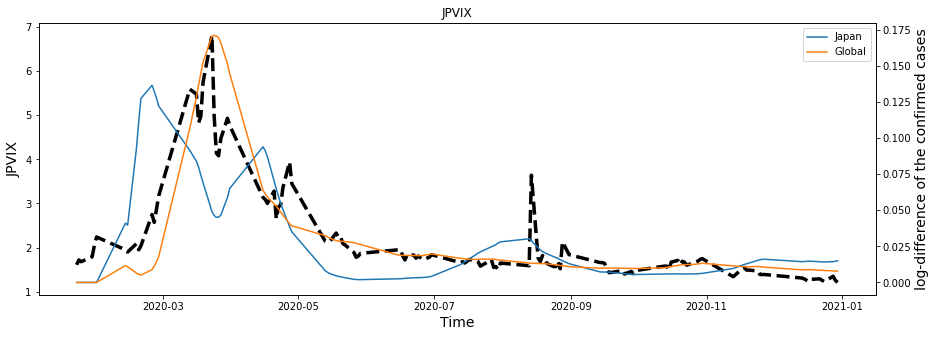

In [68]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.JPVIX , 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("JPVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_Japan'], label="Japan")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_Japan'], label='Japan')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title('JPVIX')
plt.legend()
plt.show()

Here is the situation of VHSI in Hong Kong:

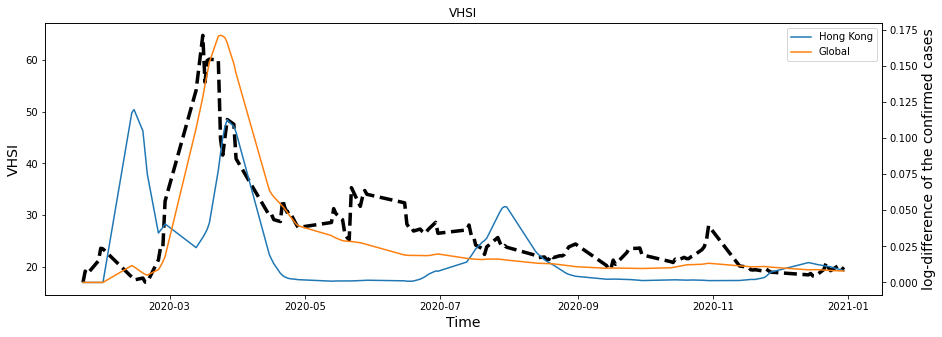

In [69]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.VHSI , 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VHSI", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_HK'], label="Hong Kong")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_HK'], label='Hong Kong')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title('VHSI')
plt.legend()
plt.show()

Here is the situation of EUVIX in Eurozone:

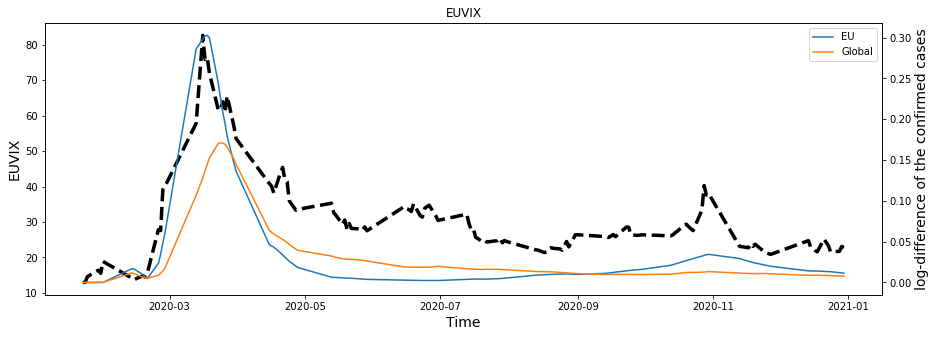

In [70]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index,data.EUVIX , 'k--',linewidth=3.5)
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("EUVIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_EU'], label="EU")
ax2.plot(data.index, data['cases_growth_global'], label='Global')
#ax2.plot(data.index, data['cases_growth_EU'], label='EU')
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("EUVIX")
plt.legend()
plt.show()

From all things above, we can learn something interesting:
* The growth of confirmed cases of all these countries/regions rise to a peak between March and April.Although Japan did not has a "peak period", its growth on confirmed rates between March and April is also greater than that of other period.
* With the growth of confirmed cases, these countries/regions volitility also rise to a peak almost in a simultaneous way.Japan may be a little different from that of others(Its volitility is much lower than others as we have shown),but the time between its "covid peak" and "VIX peak" is also very closed.
* All these volitilites rise to the peak almost at the same time as that of Global confirmed rate. Maybe it demonstrate that the financial markets in the world are connected closedly and the volitility may greatly depend on the global situation.

We plot the returns of SP500 index during COVID-19.

# Frequentist Model 

## Fitting SP500 returns by ARCH model

The autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms; often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model; if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model.

ARCH models are commonly employed in modeling financial time series that exhibit time-varying volatility and volatility clustering, i.e. periods of swings interspersed with periods of relative calm.

To implement ARCH model, we need the following 5 steps:
- Check the stationarity of the series 
- If yes, build an AR model for the mean
- Test whether the residual has conditional heteroscedasticity effect
- If yes, build an ARCH model for the volatility
- Integrate two models together

Now we follow the steps and see how the model behave in fitting SP500 returns.

In [71]:
import statsmodels.api as sm
import arch

# define load_data function
def load_data():
    '''
    prepare data for the project
    :param reload: reload data online
    :return: a dataframe
    '''

    # load sp500 and vix data use yfinance
    _finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
    _finance_data = _finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX', '^INDIAVIX':'India_VIX'}, axis=1)
    _finance_data['log_returns'] = np.log(_finance_data['SP500']).diff()
    _finance_data['returns'] = _finance_data['SP500'].pct_change()
    _finance_data['real_3w_vol'] = _finance_data['returns'].rolling(window=15).apply(pd.DataFrame.std)

    # We load covid-19 data from Johns Hopkins Coronavirus Resource Center.
    # The raw data is taken a gaussian smoothing with a 2-week window size and standard deviation 3.

    _covid_19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
            error_bad_lines=False)


    covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1).pipe(pd.DataFrame.set_index, 'Country/Region').T

    covid_19['global'] = covid_19.apply('sum', axis=1)

    # calculate the cases growth in each country
    covid_19_country = pd.DataFrame(index=covid_19.index)
    for country in covid_19.columns.unique():
            covid_19_country['cases_growth_' + country] = np.log(covid_19[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)

    # calculate the cases growth globally
    covid_19_country['cases_growth_global'] = covid_19_country.mean(axis=1)

    covid_19_data = covid_19[['US', 'global']].merge(covid_19_country[['cases_growth_US',
                                                                       'cases_growth_global',
                                                                       'cases_growth_India']],
                                                     left_index=True, right_index=True)
    
    # set covid state for US, use 0.05 as threshold line
    covid_19_data.loc[:, 'covid_state_US'] = 0
    covid_19_data.loc[covid_19_data.cases_growth_US > 0.05, 'covid_state_US'] = 1

    covid_19_data.index = covid_19_data.reset_index()['index'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%y'))

    # merge data
    data = finance_data.merge(covid_19_data, left_index=True, right_index=True)

    return data


data = load_data()
data['returns'] =  np.log(data.SP500 / data.SP500.shift(1)).fillna(0) * 100
data.tail(3)

[*********************100%***********************]  2 of 2 completed


,SP500,VIX,IDVIX,VHSI,JPVIX,EUVIX,US,global,cases_growth_US,cases_growth_global,cases_growth_India,covid_state_US,returns
2021-01-06,3748.139893,25.070000,20.995,20.02,1.36,25.07,21393464,87285672,0.010412,0.007974,0.001808,0,0.569360
2021-01-07,3803.790039,22.370001,20.615,20.58,1.37,22.37,21670202,88143734,0.010607,0.008096,0.001822,0,1.473826
2021-01-08,3824.679932,21.559999,20.640,20.15,1.32,21.56,21962246,88965298,0.010814,0.008286,0.001823,0,0.547684


####  Step 1 - Check the stationarity of SP500 returns

First we use ADF test to check whether the returns of SP500 is stationary. That is:

- Null hypothesis $H_0$: the sequence is non-stationary 

- Alternative hypothesis $H_1$: the sequence is stationary

In [72]:
# ADF test
t = sm.tsa.stattools.adfuller(data.returns) 
print ("p-value: ",t[1])

p-value:  0.008116927602952937


The p-value is less than the significance level, so the null hypothesis is rejected, Therefore. the sequence is stationary. 


#### Step 2 - Build an AR model
Autoregressive(AR) model is a statistical method of processing time series, using the same variable such as the previous periods of $x$, that is, $x_1$ to $x_{t-1}$ to predict the performance of $x_t$ in this period. And suppose they are a linear relationship. In this content, the AR model can be expressed as:

$$\begin{align*}
\qquad & r_t = c_1 + \sum_{i=1}^L{\phi_i r_{t-i}} + \epsilon_t \qquad &\epsilon_t \sim N(0,\sigma^2) \\
\end{align*}$$<br>

We use the partial autocorrelation function PACF to determine L.

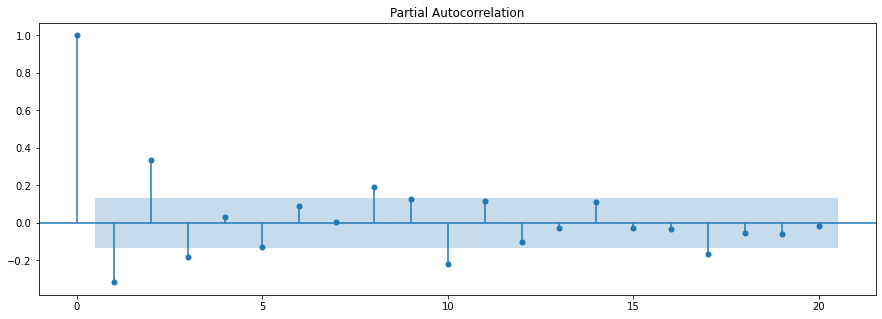

In [73]:
# plot partial autocorrelation for AR model
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
fig = sm.graphics.tsa.plot_pacf(data.returns,lags = 20,ax = ax1)

Based on the graph, we choose $L=3$ and build an AR(3) model.

In [74]:
# set L=3
L = (3,0)
# build AR model
ar_model = sm.tsa.ARMA(list(data.returns), L).fit()

/Users/jianzhou/opt/anaconda3/envs/env_generic/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


#### Step 3 - Test the autocorrelation of the residual

Let $\epsilon_t$ be the residuals

$$\epsilon_t = r_t - \hat{r}_t$$

We use Ljung-Box test to test the correlation of the sequence $\{\epsilon_t^2\}$  to determine whether it has the ARCH effect: 

- Null hypothesis $H_0$: the sequence has no serial correlation

- Alternative hypothesis $H_1$: the sequence has serial correlation

If the answer is yes, we will need to use another model to adapt to this situation.

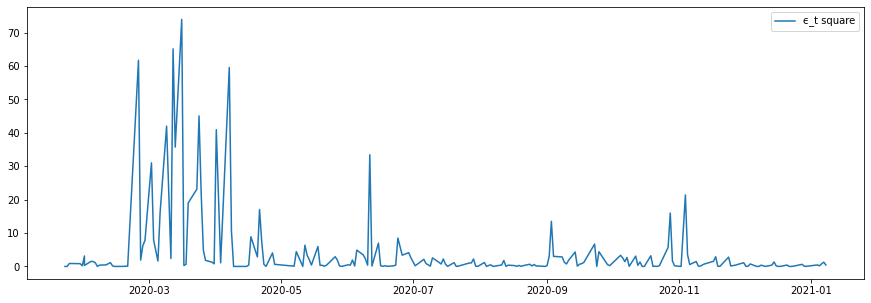

In [75]:
# Calculate the residuals
eps_t = data.returns -  ar_model.fittedvalues
eps_t2 = np.square(eps_t)

# Plot the residuals and the square of the residuals
plt.figure(figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(eps_t2,label='ϵ_t square')
plt.legend()

In [76]:
# test first 10 correlation coefficients
test_n = 10
# calculate correlation coefficients and p-value
acf, q, p = sm.tsa.acf(eps_t2, nlags = test_n, qstat = True, fft = False) 
out = np.c_[range(1,1+test_n), acf[1:], q, p]
test_output = pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"]).set_index('lag')

print("Ljung-Box test: \n")
print(test_output)

Ljung-Box test: 

            AC           Q       P-value
lag                                     
1.0   0.265932   15.276521  9.286366e-05
2.0   0.377554   46.214629  9.217661e-11
3.0   0.119272   49.316881  1.116776e-10
4.0   0.254056   63.459484  5.431137e-13
5.0   0.278102   80.487430  6.635477e-16
6.0   0.219547   91.151043  1.746981e-17
7.0   0.320419  113.974801  1.373055e-21
8.0   0.277045  131.120873  1.656755e-24
9.0   0.305743  152.105485  3.229622e-28
10.0  0.058010  152.864643  9.589244e-28


From the above result, all 10 p-values are less than the significance level of 0.05, so we reject the null hypothesis that the sequence has no autocorrelation. Therefore, it has the ARCH effect.

#### Step 4 - Build an ARCH model for the volatility

By the previous step, we conclude that AR model alone is not good enough to model the SP500 returns. We need to use ARCH model to capture the conditional heteroskedasticity of the residuals. The ARCH model can be expressed as:

$$\begin{align*}
\qquad & \epsilon_t = u_t \sigma_t  \qquad &u_t \sim N(0,1) \\
\qquad & \sigma_t^2 = k + \sum_{i=1}^p{\alpha_i \sigma_{t-i}^2} \\
\end{align*}$$

To determine the order p of the ARCH model, we again use the partial autocorrelation function PACF of $\{\epsilon^2_t\}$ sequence.

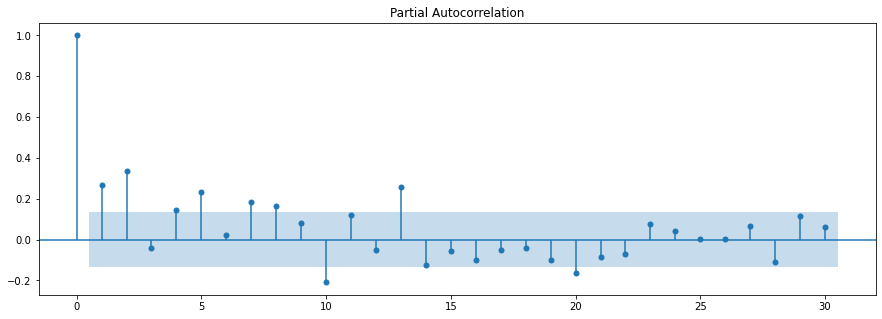

In [77]:
# plot partial autocorrelation for ARCH model
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
fig = sm.graphics.tsa.plot_pacf(eps_t2,lags = 30,ax = ax1)

From the figure above, we can let $p = 8$ and choose ARCH(8) as volatility model. 

#### Step 5 - Integrate the above two models into an AR-ARCH model
Based on our previous analysis, we can roughly choose the mean model as the AR(2) model, and the volatility model as the ARCH(8) model.

$$\begin{align*}
\qquad & r_t = c_1 + \sum_{i=1}^3{\phi_i r_{t-i}} + \epsilon_t \\
\qquad & \epsilon_t = u_t \sigma_t  \qquad &u_t \sim N(0,1) \\
\qquad & \sigma_t^2 = k + \sum_{i=1}^{8}{\alpha_i \sigma_{t-i}^2} \\
\end{align*}$$

We use the arch package in Python to implement the model.

In [78]:
# build AR-ARCH model
ar_arch = arch.arch_model(data.returns,mean='AR',lags=3,vol='ARCH',p=8)
# fit the SP500 returns data
res_ar_arch = ar_arch.fit()
# show results
res_ar_arch.summary()

Iteration:      1,   Func. Count:     15,   Neg. LLF: 1777.3452799424394
Iteration:      2,   Func. Count:     32,   Neg. LLF: 11349.314811718206
Iteration:      3,   Func. Count:     48,   Neg. LLF: 2769.622856097835
Iteration:      4,   Func. Count:     63,   Neg. LLF: 10140.35394103004
Iteration:      5,   Func. Count:     79,   Neg. LLF: 1368294.6290303043
Iteration:      6,   Func. Count:     95,   Neg. LLF: 502.1470585890378
Iteration:      7,   Func. Count:    110,   Neg. LLF: 557.4533855445918
Iteration:      8,   Func. Count:    125,   Neg. LLF: 426.5165565384275
Iteration:      9,   Func. Count:    140,   Neg. LLF: 466.96895258233826
Iteration:     10,   Func. Count:    155,   Neg. LLF: 403.9379055724394
Iteration:     11,   Func. Count:    169,   Neg. LLF: 410.69317125937476
Iteration:     12,   Func. Count:    184,   Neg. LLF: 411.0328525625082
Iteration:     13,   Func. Count:    200,   Neg. LLF: 403.2769109448485
Iteration:     14,   Func. Count:    214,   Neg. LLF: 403.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.106
Mean Model:                        AR   Adj. R-squared:                  0.093
Vol Model:                       ARCH   Log-Likelihood:               -403.238
Distribution:                  Normal   AIC:                           832.476
Method:            Maximum Likelihood   BIC:                           875.988
                                        No. Observations:                  210
Date:                Fri, Feb 05 2021   Df Residuals:                      206
Time:                        23:26:56   Df Model:                            4
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.1641      0.134      1.225      0.220 [-9.839e-02,  0.427]
returns[1]    -0.0145      0.160 -9.070e-02      0.928    [ -0.327,  0.298]
returns[2]     0.0300      0.247      0.121      0.903    [ -0.453,  0.513]
returns[3]    -0.1584  9.829e-02     -1.611      0.107  [ -0.351,3.428e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.3317      0.560      2.378  1.739e-02    [  0.234,  2.429]
alpha[1]       0.1294      0.250      0.517      0.605    [ -0.361,  0.620]
alpha[2]       0.2318      0.148      1.571      0.116 [-5.745e-02,  0.521]
alpha[3]       0.0000      0.382      0.000      1.000    [ -0.749,  0.749]
alpha[4]       0.1716      0.172      0.997      0.319    [ -0.166,  0.509]
alpha[5]       0.0000      0.164      0.000      1.000    [ -0.322,  0.322]
alpha[6]       0.0000      0.251      0.000      1.000    [ -0.492,  0.492]
alpha[7]       0.0483      0.214      0.226      0.822    [ -0.371,  0.468]
alpha[8]       0.0000      0.111      0.000      1.000    [ -0.218,  0.218]
===========================================================================

Covariance estimator: robust
"""

We get our fitting model:

$$\begin{align*}
\qquad & r_t = 0.1641 - 0.0145 r_{t-1} + 0.300 r_{t-2} - 0.1584 r_{t-3} + \epsilon_t \\
\qquad & \epsilon_t = u_t \sigma_t  \qquad & u_t \sim N(0,1) \\
\qquad & \sigma_t^2 = 1.3317 + 0.1294 \sigma_{t-1}^2 + 0.2318 \sigma_{t-2}^2 + 0.1716 \sigma_{t-4}^2 + 0.0483 \sigma_{t-7}^2 \\
\end{align*}$$

From the statistic, our model is not so suitable, since the R square and adjusted R square are both low, and AIC, BIC are both high. We then take a loot at the fitting result to find our problems.

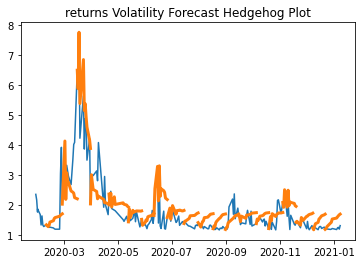

In [79]:
fig = res_ar_arch.hedgehog_plot(plot_type='volatility')
plt.rcParams['figure.figsize'] = (15, 5)
plt.show()

In the picture, the blue line is the original return rate volatility sequence, and the orange line is the predicted volatility sequence. It can be found that the spikes during 2020 March to 2020 May causes the model to overestimate the averge volatility. As a result, despite volatility went back to normal in the latter period, our model still predicts that the volatility would go up to a higher level. 

### Mini-conclusion

AR-ARCH model are commonly employed in modeling financial time series that exhibit time-varying volatility and volatility clustering. But in COVID era, it performs poorly due to extreme volatility caused by outer shocks. As a result, we must incorporate the compact of COVID into our model to better fitting the volatility spikes. 

## Fitting US VIX by ARX model

We want to add COVID as an exogenous variable in the GARCH model. Unfortunately, Python has no packages that can solve GARCH-X model, so we simplify the situation and switch to ARX model that use COVID as an exogenous variable to fit US VIX index.

First we plot the graph for VIX index and log of the COVID cases growth in US.

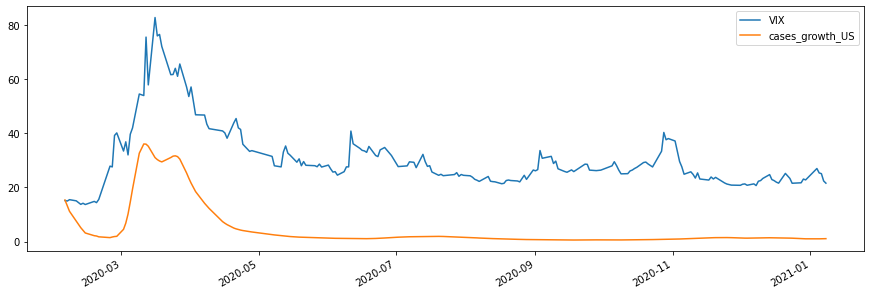

In [80]:
# get VIX data
sp500_vol = data.VIX
# drop the irrelavant data
sp500_vol = sp500_vol.loc['2020-02-05':].fillna(method='ffill')
# get COVID data
covid_us = data.cases_growth_US * 100
# drop the irrelavant data
covid_us = covid_us.loc['2020-02-05':]
# plot the figure
sp500_vol.plot(figsize=(15,5))
covid_us.plot()
plt.legend()
plt.show()

Then we use ARX to fit the data. That is:

\begin{align*}
\qquad & vol_t = c_1 + \phi_1 vol_{t-1} + \alpha_1 covid_t + \epsilon_t \qquad &\epsilon_t \sim N(0,\sigma^2)\\
\end{align*}

In [81]:
from arch.univariate import ARX, Normal
# build ARX model
arx_model = ARX(y = sp500_vol, x = covid_us, lags=1, distribution=Normal())
# fit our data
res_arx = arx_model.fit()
# show results
res_arx.summary

/Users/jianzhou/opt/anaconda3/envs/env_generic/lib/python3.7/site-packages/arch/univariate/mean.py:483: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self._x = self._x[:, None]


<bound method ARCHModelResult.summary of                     AR-X - Constant Variance Model Results                    
Dep. Variable:                    VIX   R-squared:                       0.905
Mean Model:                      AR-X   Adj. R-squared:                  0.904
Vol Model:          Constant Variance   Log-Likelihood:               -552.984
Distribution:                  Normal   AIC:                           1113.97
Method:            Maximum Likelihood   BIC:                           1127.22
                                        No. Observations:                  203
Date:                Fri, Feb 05 2021   Df Residuals:                      200
Time:                        23:26:56   Df Model:                            3
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          5.5934  

Our fitting model is:

$$\begin{align*}
\qquad & vol_t = 5.5934 + 0.7749 vol_{t-1} + 0.2969 covid_t + \epsilon_t \qquad &\epsilon_t \sim N(0,13.6023)\\
\end{align*}$$

It is good news that all the p-values are less than the significant level and adjusted R square is large. However, we still see that AIC and BIC is high, which is not satisfying. Also, we need to check whether the model has the ARCH effect.

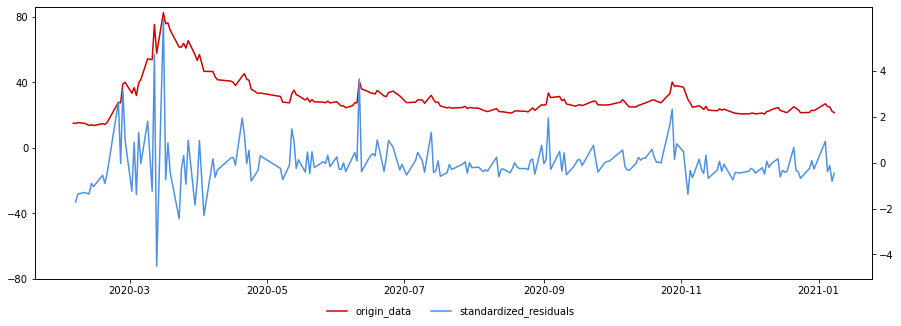

In [82]:
# plot the residuals and original data
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5),)
ax2 = ax1.twinx()
blue = tuple(np.array([78, 145, 224]) / 255)
red = tuple(np.array([205, 0, 0]) / 255)
ax1.plot(sp500_vol,label='origin_data',color=red)
ax2.plot(res_arx.std_resid,label='standardized_residuals',color=blue)
ax1.set_yticks(np.arange(-80,120,40))
ax2.set_yticks(np.arange(-4,6,2))
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend1 = fig.legend(handles1+handles2, labels1+labels2,loc='lower center',ncol=2,frameon=False)
plt.show()

By the results above, the model has the problem of conditional heteroskedasticity, so ARX with COVID is not enough to model the data.

### Mini-conclusion

while adding COVID data into our frequentist model significantly improves our result, it still has several issues. First, there is no ARCH-X or GARCH-X model that we can use in current Python environment, so the result above is just an approximation by VIX data, which does not accurately demonstrate the volatility of real SP500 volatility. Second, our ARX model has ARCH effect, which means ARX alone can not fully capture the patterns of VIX index.

### From Random Walk to Free Scale - The Evolution of Stochastic Volatility Model

### Baseline Model: RW Stochastic Volatility

We start from the most basic stochastic volatility model, namely,
volatility follows a random walk latent process without any exogenous
variables.

Mathamatically speaking,

\begin{align*}
\qquad & y_t = \beta e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} = \mu + \phi (h_{t-1} - \mu) + \sigma_{\eta} \eta_{t}  \qquad \qquad &\eta_{t} \sim N(0,1) \\
\end{align*}

We use an informative prior, setting $\beta = 1$ and $\mu = 0$ to facilitate
computation and subsequent analysis.
##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,0, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \sigma_\eta \sim Exp(10) \\
\qquad & h_{t} = h_{t-1} + \sigma_{\eta}* \eta_{t}   \\
\end{align*}

We use NUTS to sample the Random Walk Model.

Also we define some common-used utils functions.

In [ ]:
# Utils Functions

def load_data(regular = True, reload=False):
    '''
    prepare data for the project
    :param regular: for developers only
    :param reload: reload data online
    :return: a dataframe
    '''
    if not reload:
        if os.path.exists("../Data/data.pkl"):
            data = pd.read_pickle("../Data/data.pkl")
            return data
        else:
            return load_data(reload=True)

    # load sp500 and vix data use yfinance
    _finance_data = yf.download("^GSPC ^VIX", start="2017-01-01", end="2021-01-11")['Adj Close']
    _finance_data = _finance_data.rename({'^GSPC':'SP500', '^VIX':'VIX', '^INDIAVIX':'India_VIX'}, axis=1)
    _finance_data['log_returns'] = np.log(_finance_data['SP500']).diff()
    _finance_data['returns'] = _finance_data['SP500'].pct_change()
    _finance_data['real_3w_vol'] = _finance_data['returns'].rolling(window=15).apply(pd.DataFrame.std)

    try:
        VIX_india = pd.read_csv("indian vix.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()) .pipe(
            pd.DataFrame.rename, {'Close':'India_VIX'}, axis=1) .pipe(pd.DataFrame.set_index, ['Date'])
    except FileNotFoundError:
        VIX_india = pd.read_csv("../indian vix.csv").pipe(pd.DataFrame.rename, columns=lambda x: x.strip()).pipe(
            pd.DataFrame.rename, {'Close': 'India_VIX'}, axis=1).pipe(pd.DataFrame.set_index, ['Date'])
    VIX_india.index = VIX_india.reset_index()['Date'].apply(lambda i : datetime.datetime.strptime(i, '%d-%b-%y'))
    finance_data = _finance_data.merge(VIX_india, left_index=True, right_index=True)



    # We load covid-19 data from Johns Hopkins Coronavirus Resource Center.
    # The raw data is taken a gaussian smoothing with a 2-week window size and standard deviation 3.


    # load covid-19 data from Johns Hopkins Coronavirus Resource Center
    # code for Bo Sun only
    if regular:
        _covid_19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
                error_bad_lines=False)
    else:
        _covid_19 = pd.read_csv(r"C:\Users\harvey_sun\Desktop\data\time_series_covid19_confirmed_global.csv")


    covid_19 = _covid_19.pipe(pd.DataFrame.drop, ['Province/State', 'Lat', 'Long'], 1)         .pipe(pd.DataFrame.set_index, 'Country/Region').T

    covid_19['global'] = covid_19.apply('sum', axis=1)

    # calculate the cases growth in each country
    covid_19_country = pd.DataFrame(index=covid_19.index)
    for country in covid_19.columns.unique():
            covid_19_country['cases_growth_' + country] = np.log(covid_19[[country]].sum(axis=1).replace(0,1)).diff().rolling(14, win_type='gaussian').mean(std=3)

    # calculate the cases growth globally
    covid_19_country['cases_growth_global'] = covid_19_country.mean(axis=1)

    covid_19_data = covid_19[['US', 'global']].merge(covid_19_country[['cases_growth_US',
                                                                       'cases_growth_global',
                                                                       'cases_growth_India']],
                                                     left_index=True, right_index=True)
    # set covid state for US, use 0.05 as threshold line
    covid_19_data.loc[:, 'covid_state_US'] = 0
    covid_19_data.loc[covid_19_data.cases_growth_US > 0.05, 'covid_state_US'] = 1

    covid_19_data.index = covid_19_data.reset_index()['index'].apply(lambda i : datetime.datetime.strptime(i, '%m/%d/%y'))

    # merge data
    data = finance_data.merge(covid_19_data, left_index=True, right_index=True)
    if not os.path.exists("../Data"):
        os.mkdir("../Data")
    data.to_pickle("../Data/data.pkl")
    return data

def model_diagnose(model, trace, var_names):
    '''
    diagnose a model based on 'Effective Sample Size and Rhat

    :param model: a PyMC3 model
    :param trace: sample trace
    :param var_names: variable names
    :return: None
    '''
    ess = az.ess(trace, relative=True)

    print("Effective Sample Size (min across parameters)")
    for var in var_names:
        print(f"\t{var}: {ess[var].values.min()}")
    rhat = az.rhat(trace)

    print("rhat (max across parameters)")
    for var in var_names:
        print(f"\t{var}: {rhat[var].values.max()}")

def gen_xy(trace, _data, y="log_vol", AR=False, skip=5):
    '''
    generate posterior predictive y from trace

    :param trace: sample trace
    :param _data: observation data
    :param y: y column anme
    :param AR: whether it's a AR model
    :param skip: how often take draws from trace, only take 1 draw after skip steps
    :return: x values from observation data, y values from posterior predictive
    '''
    _y_vals = np.exp(trace.posterior[y])
    y_vals = np.vstack([_y_vals[i] for i in range(_y_vals.shape[0])]).T
    if AR:  # take the last n-1 values, because AR1 process has an extra starting point
        y_vals = y_vals[:-1, ]
    # only take 1 draw after skip steps
    y_vals = y_vals.T[::skip].T
    x_vals = np.vstack([_data.index for _ in y_vals.T]).T.astype(np.datetime64)
    return x_vals, y_vals

def model_plot(data, trace, pp, AR=False):
    '''
    plot returns and volatility
    :param data: observation data
    :param trace: sample trace
    :param pp: posterior predictive
    :param AR: whether it's a AR model
    :return: figures
    '''
    x = data.index.to_numpy().astype(np.datetime64)
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    # Plot returns
    ax[0].plot(
        x, pp["returns"][::10].T, color="g",
        alpha=0.25, zorder=-10
    )
    ax[0].plot(x, data["log_returns"].to_numpy(), color="k", linewidth=2.5, label="log returns")
    ax[0].set(title="Posterior predictive log-returns (green) VS actual log-returns", ylabel="Log Returns")

    # Plot volatility
    _, y_vals = gen_xy(trace, data, AR=AR, skip=10)
    ax[1].plot(x, y_vals, "k", alpha=0.01)
    ax[1].plot(data.index, data['real_3w_vol'], linewidth=2.5, label="realized 3W vol")
    ax[1].set(title="Estimated volatility over time (balck) vs realized vol", ylabel="Volatility")
    ax[1].set_ylim(bottom=0)

    # Add legends
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")
    plt.tight_layout()

data = load_data(reload=True)

In [ ]:
# Code for Random Walk
# %aimport stovol.baseline
# baseline_model_RW = stovol.baseline.make_baseline_model_RW(data, "log_returns")

def make_baseline_model_RW(data, observe):
    '''model for Random Walk StoVol'''
    with pm.Model() as model:
        # Piror
        nu = pm.Exponential("nu", 0.1)
        scale = pm.Exponential("scale", 10)
        log_vol = pm.GaussianRandomWalk("log_vol", sigma=scale, shape=len(data))
        # Likelihood
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2 * log_vol), observed=data[observe])
    return model

baseline_model_RW = make_baseline_model_RW(data, "log_returns")

with baseline_model_RW:
    trace_RW = pm.sample(2000, tune=2000, return_inferencedata=True)
    _var_names = ['nu', 'scale']
    model_diagnose(baseline_model_RW, trace_RW, _var_names)
    az.plot_trace(trace_RW, var_names=_var_names)
    pp_RW = pm.sample_posterior_predictive(trace_RW)

We plot the posterior predictive returns and volatility.

There are 4 chains and each chian have 2000 steps.

We take every 5th of the draws and yield 1600 paths.

In [ ]:
model_plot(data=data, trace=trace_RW, pp=pp_RW)

### Model Extension: AR1 Stochastic Volatility

Recall the stochastic volatility model is defined by,

\begin{align*}
\qquad & y_t = e^{h_t/2} \epsilon_t\qquad \qquad &\epsilon_t \sim N(0,1) \\
\qquad & h_{t} - \mu= \phi(h_{t-1} - \mu) + \sigma_{\eta} \eta_{t}  \qquad \qquad &\eta_{t} \sim N(0,1) \\
\end{align*}

The Random Walk Stochastic Volatility Model coerces the correlation
between $h_{t}$ and $h_{t-1}$ to be 1 (in our case, $\phi=1$).

However, it doesn't have to
be 1, and hence, we free up that parameter and change the model
setting to be a AR1 process.

Note that $\mu$ is not being set to 0 (like what we have done in
Random Walk Stochastic Volatiltiy Model), instead, we treat $\mu$
as a model parameter to fit.

##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,\mu, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \phi \sim \mathcal{N}(0, 1) \\
\qquad & \sigma_\eta \sim Exp(10) \\
\qquad & \mu \sim \mathcal{N}(0, 1) \\
\qquad & h_{t} - \mu = \phi(h_{t-1} - \mu)+ \sigma_\eta* \eta_{t}   \\
\end{align*}

We beef up the tuning iterations from 2k to 4k as the model complexity increases.

Also, we hardcode the random seed as 1234 to avoid initialization failure.

In [ ]:
# Code for AR1
def make_baseline_model_AR1(data, observe):
    '''
    model for AR1 StoVol

    :param data: observation data
    :param observe: column name of y
    :return: PyMC model
    '''
    with pm.Model() as model:
        # Piror
        # phi = pm.Beta("phi", alpha=20, beta=1.5)
        np.random.seed(12345)
        phi = pm.Normal("phi", mu=1, sigma=1, testval=np.random.randn())
        # scale = pm.InverseGamma("scale", alpha=2.5, beta=0.05)
        scale = pm.Exponential("scale", 10, testval=np.random.randn())
        _log_vol = pm.AR1("_log_vol", k=phi, tau_e=1/pm.math.sqr(scale), shape=len(data), testval=np.random.randn(len(data)))
        # mu = pm.Exponential('mu', lam=0.1)
        mu = pm.Normal('mu', mu=0, sigma=1)
        log_vol = pm.Deterministic("log_vol", _log_vol + mu)
        mean_return = pm.Normal("mean_return", 0, 1)
        nu = pm.Exponential("nu", 0.1)
        # Likelihood
        # returns = pm.Normal("returns", mu=mean_return, sigma=np.exp(log_vol/2), observed=data[observe])
        returns = pm.StudentT("returns", nu=nu, mu=mean_return, lam=np.exp(-2 * log_vol), observed=data[observe])
    return model

baseline_model_AR = make_baseline_model_AR1(data, "log_returns")

with baseline_model_AR:
    trace_AR = pm.sample(2000, tune=4000, return_inferencedata=True)
    _var_names = ["mean_return", "phi", "scale", "mu", "nu"]
    model_diagnose(baseline_model_AR, trace_AR, _var_names)
    az.plot_trace(trace_AR, var_names=_var_names)
    pp_AR = pm.sample_posterior_predictive(trace_AR)

<pre>
Simplicity is the ultimate sophistication.
                                --Leonardo da Vinci
</pre>
The posterior distributions echo the Leonardo da Vinci famous saying.

Even though we have allowed more free parameters in the model, neither do we
receive noticeable model improvements as shown in graphs below compared to the
more parsimonious random walk model, nor do the posteriors distrubtions provide
sufficient evidences.

The posteriors of mean_return center around 0.002, $\phi$ cluster at 1 and $\mu$
is spreading across the support.

This results shows that assumptions under classical stochastic
volatility model are mostly reasonable and supported by empirical data.
To be more specific, mean of log-return is 0, log-volatility is a
random walk process and the mean of log-volatility is 0.

In [ ]:
model_plot(data=data, trace=trace_AR, pp=pp_AR)

### Model Extension: Two-State AR1 Stochastic Volatility

Recall the stylized fact that COVID-19 greatly impacts realized and implied
volatility and market indices per se, which motivate us to incorporate COVID data
in volatility analysis.

We initiate a two-stage model - high-vol stage and low-vol stage,
which is identifed by COVID-19. A period with high COVID
infection number is in high-vol state, while a period with low COVID
infection is in low-vol state.

##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,\mu, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \phi \sim \mathcal{N}(0, 1) \\
\qquad & scale \sim Exp(10) \\
\qquad & h_{t} = \phi h_{t-1}+ scale_s* \epsilon_{t} \qquad s \in (low\_vol, high\_vol)  \\
\end{align*}

Exploring with the method of trial and errors, we argue that log-difference
log-difference of the confirmed cases being 5% is a decent cut-off point to seperate
high-vol and low-vol state.

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
# make a plot
ax.plot(data.index, data.VIX, color="red")
# set x-axis label
ax.set_xlabel("Time", fontsize=14)
# set y-axis label
ax.set_ylabel("VIX", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data.index, data['cases_growth_US'], label="US")
ax2.axhline(y=0.05, color='black', linestyle='--', linewidth=2.5)
ax2.set_ylabel("log-difference of the confirmed cases", fontsize=14)
ax2.set_title("5% is a decent cutoff point", fontsize=14)
plt.legend()
plt.show()

In [ ]:
# Code for Two-State Model
def make_state_model_AR1(data, observe):
    '''
    model for Two-State StoVol

    :param data: observation data
    :param observe: column name of y
    :return: PyMC model
    '''
    # Prepare data
    nstate = data['covid_state_US'].nunique()
    log_returns = data[observe].to_numpy()
    state_idx = data["covid_state_US"].to_numpy()

    with pm.Model() as model:
        # Data
        _returns = pm.Data("_returns", log_returns)
        _state_idx = pm.intX(pm.Data("state_idx", state_idx))
        # Prior
        scale = pm.InverseGamma("scale", alpha=2.5, beta=0.05, shape=nstate)
        log_vol = pm.GaussianRandomWalk('log_vol', mu=0, sigma=scale[_state_idx], shape=len(data))
        nu = pm.Exponential("nu", 0.1)
        # Likelihood
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2 * log_vol), observed=_returns)
    return model

model_state = make_state_model_AR1(data, "log_returns")

with model_state:
    trace_state = pm.sample(2000, tune=2000, return_inferencedata=True)
    _var_names = ["scale", "nu"]
    model_diagnose(model_state, trace_state, _var_names)
    az.plot_trace(trace_state, var_names=_var_names)
    pp_state = pm.sample_posterior_predictive(trace_state)

The orange chains of scale paramters stands for $\sigma_\eta$ in
high-infection time while the blue chairs are in low-infection time.

The posterior distribution of the scale pamater $\sigma_\eta$ tells
a very attractive story -  the latent volatility process is mild and
steady under gentle contagious spread, but if covid-19 spreads quickly,
the volatility process also go wild.


In [ ]:
model_plot(data=data, trace=trace_state, pp=pp_state)

We compare the Two-state model vs the Random walk model.

The black paths are estimated volatility from two-state model,
and red paths arefrom random walk model.
The two-state model paths are enveloped by that of randome walk model,
illustrating that two-state model provide a narrower range of
posterior prediction.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

x_vals, y_vals = gen_xy(trace_state, data)
plt.plot(x_vals, y_vals, "black", alpha=0.002)

# comparison with baseline model
x_vals, y_vals = gen_xy(trace_RW, data)
plt.plot(x_vals, y_vals, "red", alpha=0.002)
plt.plot(data.index, data['real_3w_vol'], linewidth=2.5)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time - "
             "two-state model (black) provide better prediction than random walk model (red) ",
       xlabel="Date", ylabel="Volatility")
plt.show()

### Model Extension: Free-Scale Stochastic Volatility

The two-state model sheds light on the interrelation betwen market
volatility and COVID infection.

We are explorers and unsatisfied about the discrete state-space
representation of the model.

Hence we decide to do some heavylifting - introducing covid-19
as exogeneous variable to the volatiltiy process.

More specifically, we set the scale
parameter $\sigma_\eta$ to be a random walk process with a drift
determined by COVID infection and here comes the name
**Free-Scale Stochastic Volatility** as $\sigma_\eta$ is termed
*scale* in the literature.

##### Model Setting
The likelihood is given by
\begin{align*}
\qquad & log(y_t) \sim StudentT(\nu,\mu, e^{h_t}) \\
\end{align*}

The priors are given by
\begin{align*}
\qquad & \nu \sim Exp(0.1) \\
\qquad & \phi \sim \mathcal{N}(1, 1) \\
\qquad & h_{t} = \phi h_{t-1}+ \sigma_{\eta, t}* \eta_{t} \\
\qquad & \sigma_{\eta, t} = \sigma_{\eta, t-1} + \alpha*(lnC_t - lnC_{t-1}) + u_t \\
\end{align*}

We start from the easiest -  assume the log-vol process is a random walk ($\phi=1$)

In [ ]:
# Code for Free-Scale Stochastic Volatility assumeing a RW log-vol process

def make_covid_model(data, observe, col_covid="cases_growth_US", process='GRW'):
    '''
    model for Free-Scale StoVol

    :param data: observation data
    :param observe: column name of y
    :param col_covid: column name of covid data
    :param process: process of the scale paramter, can be GRW or AR1
    :return: PyMC model
    '''

    if data[col_covid].hasnans:
        raise ValueError(f"{col_covid} has NaN values")

    log_returns = data[observe].to_numpy()

    with pm.Model() as model:
        # Data
        _returns = pm.Data("_returns", log_returns)
        # _change_returns = pm.Data("_change_returns", data[observe_str], dims=observe_str, export_index_as_coords=True)
        _covid = pm.Data("covid", data[col_covid])

        # HyperPrior
        alpha = pm.Normal("alpha", mu=1, sigma=1, testval=np.random.random())
        scale = pm.GaussianRandomWalk("scale", mu=alpha*_covid, sigma=1, shape=len(data),
                                      testval=np.random.randint(low=1, high=10, size=len(data)))
        # Prior
        if process == 'GRW':  # scale follows a Gaussian Random Walk
            log_vol = pm.GaussianRandomWalk("log_vol", sigma=scale, shape=len(data),
                                        testval=np.random.randint(low=1, high=10, size=len(data)))
        elif process == 'AR1': # scale follows a AR1
            phi = pm.Beta("phi", alpha=20, beta=1.5)
            # phi = pm.Normal("phi", mu=1, sigma=1, testval=np.random.randint(low=1, high=10))
            log_vol = pm.AR1("log_vol", k=phi, tau_e=1 / pm.math.sqr(scale), shape=len(data)+1,
                             testval=np.random.randint(low=1, high=10, size=len(data)+1))[:-1]
        nu = pm.Exponential("nu", 0.1)

        # Likilihood
        returns = pm.StudentT("returns", nu=nu, lam=np.exp(-2 * log_vol), observed=_returns)
    return model

data_cmodel = data.dropna(subset=['cases_growth_US'])
model_covid = make_covid_model(data_cmodel, "log_returns")

with model_covid:
    trace_covid = pm.sample(3000, tune=4000, return_inferencedata=True)
    _var_names = ["alpha", "nu"]
    model_diagnose(model_covid, trace_covid, _var_names)
    az.plot_trace(trace_covid, var_names=_var_names)
    pp_covid = pm.sample_posterior_predictive(trace_covid)

In [ ]:
model_plot(data=data_cmodel, trace=trace_covid, pp=pp_covid)

The Free-Scale Stochastic Volatility behave disappointing - it's even
worse than the Two-state model, despite of much more complexity added.

We are wondering whether the moderate performance results from the
assmumption that log-vol process is a random walk, and hence
decide to sample the model with a AR1 log-vol process.

In [ ]:
# Code for Free-Scale Stochastic Volatility assumeing a AR log-vol process
data_cmodel = data.dropna(subset=['cases_growth_US'])
model_covid_AR = make_covid_model(data_cmodel, "log_returns", process='AR1')

with model_covid_AR:
    trace_covid_AR1 = pm.sample(3000, tune=4000, return_inferencedata=True)
    _var_names = ["alpha", "phi", "nu"]
    model_diagnose(model_covid_AR, trace_covid_AR1, _var_names)
    az.plot_trace(trace_covid, var_names=_var_names)
    pp_covid_AR = pm.sample_posterior_predictive(trace_covid_AR1)


##### NUTS vs Metropolis-Hasting
The NUTS don't work for our model seting. Based on debugging/error info,
our model are stuck where gradient are 0.

This naturally motivates use to use the Metropolis-Hasting algorithm,
which doesn't rely on gradients.

Also, the seminal paper
``Stochastic Volatility- Likelihood Inference and Comparison with ARCH Models``
 from Sangjoon Kim, Neil Shephard and Siddhartha Chib also use MH
 algorithm.

Hence, even with the following cavents from PyMC3 documentations, we
change the proposal step from NUTS to Metropolis-Hasting algo.

We increase the tuning and sampling periods drasticaly as MH algo is
fast.
<pre>
For almost all continuous models, NUTS should be preferred.

There are hard-to-sample models for which NUTS will be very slow causing
many users to use Metropolis instead.

This practice, however, is rarely successful. NUTS is fast on simple models but can be slow if the model is very complex
or it is badly initialized.

In the case of a complex model that is hard for NUTS, Metropolis, while faster, will have a very low effective sample
size or not converge properly at all.
A better approach is to instead try to improve initialization of NUTS, or reparameterize the model.
                                                                                        --PyMC3 Documentation
</pre>


In [ ]:
# Code for Free-Scale Stochastic Volatility assumeing a AR log-vol process
with model_covid_AR:
    # stepNUTS = pm.NUTS(vars=[model_covid_AR.alpha,
    #                          model_covid_AR.scale,
    #                          model_covid_AR.phi,
    #                          model_covid_AR.nu])
    # stepMH = pm.Metropolis(vars=[model_covid_AR.log_vol])
    # trace_covid_AR1 = pm.sample(8000, tune=8000, step=[stepNUTS,
    #                                                stepMH],
    #                         return_inferencedata=True)
    trace_covid_AR1 = pm.sample(8000, tune=8000, step=pm.Metropolis(),
                            return_inferencedata=True)
    _var_names = ["alpha", "nu", "phi"]
    model_diagnose(model_covid_AR, trace_covid_AR1, _var_names)
    az.plot_trace(trace_covid_AR1, var_names=_var_names)
    pp_covid_AR = pm.sample_posterior_predictive(trace_covid_AR1)

The Metropolis-Hasting algorithm generates decent posterior distributions
for $\alpha$ and $\nu$, but fail for $\phi$, also the posterior
prediction indicate strong overfitting problem. Our predictions
explode and hit the sky in some periods.

In [ ]:
model_plot(data=data_cmodel, trace=trace_covid_AR1, pp=pp_covid_AR, AR=True)

##### Mini-conclusion
* We propose and test four Bayesian Stochatic Volatility Models,
among which the Two-state model perform the best.
* Having say best performance, we mean that two-state model is
parsimonious and responsive to COVID-19 shock.
* The Free-Scale Model is difficult to compute, and also suffer
from severe overfitting problem.

### Conclusion
Motivated by the stylized fact that VIX and COVID-19 infection number
peak simultaneously, we try to model the co-movement using frequentist
and bayesian methods.

* Frequentist method - The ARCH model fail to incorporate the
COVID-19 shock.
* Bayesian method - Wepropose and test four models, among
which a state-space representation model yield the best performance.
* We think our results and discoveries related to COVID-19 is
transferable to other events. We can model and gain posterior distributions
for any other sentiment or volatility shocks by state-space
representation and Monte-Carlo Markov Chain simulation.

